# Gene set enrichment analysis of rho scores

<!-- Luke and Ray has shared the CRISPRi screening results which was analyzed with [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing) pipeline.  -->

<!-- - $\gamma$ - gamma score -->
<!-- - $\rho$ - rho score -->

<!-- - Load screening result tables into python 
- Make sure gene names are correctly assigned 
 -->

<!-- Alex Ge: 
> If we do Enrichr analysis on the resistance/sensitivity hits defined by Max’s cutoffs, (n = 418 genes), we do see mRNA methylation (adj p = 0.018) and RNA destabilization (adj p = 0.005) come out as significant GO biological processes. METTL3 is included in these GO terms.

> If we do Enrichr analysis on just the resistance hits (n = 197), mRNA methylation is even more significant (adj p = 0.002), which makes sense since we see more METTL3 biology on the resistance side. It is one of the top five GO terms by adjusted P-value.

> This analysis was done today with the 2021 GO terms, which have updated annotations for the newer m6A genes. When I did the same Enrichr analysis in 2018, RNA destabilization and mRNA methylation were not as significant since the GO annotations were not updated.

> I think Enrichr analysis might make more sense here – in Abe’s analysis, I can see that a lot of rho scores that are < 0.2 are being included in the analysis; these are likely to be statistically insignificant. It also looks graphically like the highest bin is including rho values that are < 0?
 -->
- tool: blitzgsea, https://github.com/MaayanLab/blitzgsea

In [1]:
import sys
import pandas as pd
import numpy as np 
from itertools import chain, product

sys.path.append("../../")
pager_dir = "/data_gilbert/home/aarab/Projects/pager/"
pager_annotation_path = '/data_gilbert/home/aarab/Projects/pager/annotations/human'

from scripts.util import *
from matplotlib_venn import venn2
from IPython.display import IFrame

In [2]:
import gseapy

In [3]:
def get_sig_gsea_results(result,variable,threshold):
    return result[result[variable] < threshold]

In [4]:
wd = '/data_gilbert/home/aarab/Projects/Decitabine-treatment/DAC'

In [5]:
data = load_data(screens=True,wd=wd)

In [6]:
data.keys()

dict_keys(['hl60_exp1_DAC_rho', 'hl60_exp1_DAC_gamma', 'hl60_exp2_DAC_rho', 'hl60_exp2_DAC_gamma', 'hl60_exp2_GSK_rho', 'hl60_exp2_GSK_gamma', 'molm13_exp_DAC_rho', 'molm13_exp_DAC_gamma', 'molm13_exp_GSK_rho', 'molm13_exp_GSK_gamma'])

## Run GSEA

In [7]:
import blitzgsea as blitz
import urllib.request
import pandas as pd

In [8]:
rho = data['hl60_exp1_DAC_rho'].reset_index().iloc[:,[0,1]]
rho.iloc[:,1] = np.double(rho.iloc[:,1])
rho = rho.dropna()
# rho = rho[rho.iloc[:,1].abs() > 0.01]

In [9]:
rho_stat = data['hl60_exp1_DAC_rho'].reset_index().iloc[:,[0,2]]
rho_stat.iloc[:,1] = 1 - np.double(rho_stat.iloc[:,1])
rho_stat = rho_stat.dropna()

# 

In [ ]:
table_s1 = {}

## Regardless of direction

#### c5_go_gmt

In [10]:
c5_go_gmt = blitz.enrichr.read_gmt(
    f'{pager_annotation_path}/msigdb_v7.4_c5.go/c5.go.v7.4.symbols.gmt'
)

In [11]:
# signature = rho.copy()
signature = rho_stat.copy()

result_go = blitz.gsea(
    signature=signature,
    library=c5_go_gmt,
    min_size=200,
    # max_size=250,
    verbose=True
)

Enrichment : 100%|██████████| 10185/10185 [00:01<00:00, 6564.59it/s]


In [96]:
result_go[
    (result_go.leading_edge.str.contains('METTL3')) &
    (result_go.leading_edge.str.contains('DCPS'))
]

,es,nes,pval,sidak,fdr,geneset_size,leading_edge
Term,,,,,,,
GOBP_RNA_SPLICING_VIA_TRANSESTERIFICATION_REACTIONS,0.277390,3.803455,0.000143,0.114229,0.026157,330,"CSTF3,DAZAP1,ZBTB7A,AAR2,YTHDC1,DCPS,FIP1L1,HN..."
GOBP_RNA_SPLICING,0.267862,3.622427,0.000292,0.219726,0.041346,417,"DAZAP1,CSTF3,SCAF1,ZBTB7A,HNRNPLL,AAR2,MBNL1,Y..."
GOBP_MRNA_PROCESSING,0.268028,3.221993,0.001273,0.661340,0.108979,474,"DAZAP1,CSTF3,SCAF1,ZBTB7A,SCAF8,HNRNPLL,AAR2,Y..."
GOBP_RNA_CATABOLIC_PROCESS,0.237531,2.819448,0.004811,0.983409,0.214164,388,"DCPS,DCP2,SSB,PSMD11,DHX36,RPL12,PUM1,GTPBP1,H..."
GOMF_CATALYTIC_ACTIVITY_ACTING_ON_RNA,0.215572,1.814213,0.069645,1.000000,0.978872,330,"MED20,DDX49,DDX54,ALKBH8,DHX29,DCPS,DCP2,TRMT1..."
GOBP_RNA_PROCESSING,0.256337,0.867696,0.385561,1.000000,1.000000,863,"DAZAP1,ZBTB7A,SCAF8,YTHDC1,ALKBH8,UTP23,ZC3H13..."
GOBP_MRNA_METABOLIC_PROCESS,0.248614,0.812918,0.416265,1.000000,1.000000,791,"DAZAP1,ZBTB7A,SCAF8,YTHDC1,MED1,CBLL1,DCP2,ZC3..."
GOMF_RNA_BINDING,0.215021,0.000000,1.000000,1.000000,1.000000,1512,"DAZAP1,HSP90B1,SCAF8,YTHDC1,ALKBH8,DCP2,RFTN1,..."
GOBP_ORGANIC_CYCLIC_COMPOUND_CATABOLIC_PROCESS,0.196708,0.000000,1.000000,1.000000,1.000000,602,"DDX49,AFMID,HSF1,ACOT7,NMNAT1,GSK3A,HPD,DCPS,D..."


In [108]:
pd.DataFrame(c5_go_gmt['GOBP_MRNA_PROCESSING']
).to_csv(
    'GOBP_MRNA_PROCESSING.txt',index=False,header=None
)

In [101]:
pd.DataFrame(result_go[
    result_go.index == 'GOBP_MRNA_PROCESSING'
].leading_edge.str.split(',')[0]).to_csv(
    'GOBP_MRNA_PROCESSING_gsea_leading_edge.csv',index=False,header=None
)

In [ ]:
# fig_table = blitz.plot.top_table(
#     signature, c5_go_gmt, 
#     result_go.loc[['GOBP_NUCLEAR_TRANSCRIBED_MRNA_CATABOLIC_PROCESS','GOBP_RNA_MODIFICATION']]
#     , n=2
# )

# fig_table
# # fig_table.savefig("plots/CRISPRi-rho-gsea-GO.pdf", bbox_inches='tight')

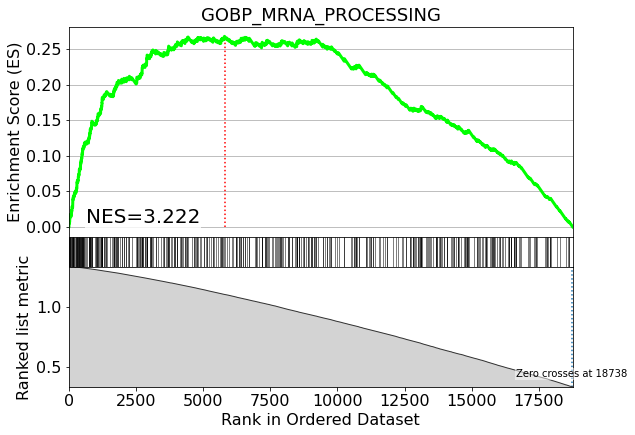

In [12]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOBP_MRNA_PROCESSING", 
                             c5_go_gmt, result_go, compact=False)
fig
# fig.savefig("plots/CRISPRi-rho-gsea-KEGG_P53_SIGNALING_PATHWAY.pdf", bbox_inches='tight')

In [16]:
table_s1['Regardless of direction'] = result_go

## Based on direction

#### c5_go_gmt

In [17]:
signature = rho.copy()
# signature = rho_stat.copy()

result_go = blitz.gsea(
    signature=signature,
    library=c5_go_gmt,
    min_size=15,
    max_size=150,
    verbose=True
)

Enrichment : 100%|██████████| 10185/10185 [00:07<00:00, 1454.80it/s]


In [18]:
table_s1['Based on direction'] = result_go

## Write results

In [20]:
table_s1.keys()

dict_keys(['Regardless of direction', 'Based on direction'])

In [ ]:
get_sig_gsea_results(
    table_s1['Based on direction'],'pval',0.05
)

(357, 7)

In [50]:
with pd.ExcelWriter("Table S1-v4.xlsx") as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet

    get_sig_gsea_results(
        table_s1['Based on direction'],'pval',0.05
    ).to_excel(writer, index=True, sheet_name="Based on direction") 
    
    get_sig_gsea_results(
        table_s1['Regardless of direction'],'pval',0.05
    ).to_excel(writer, index=True, sheet_name="Regardless of direction") 

## Resistance hits

### KEGG_P53_SIGNALING_PATHWAY

In [ ]:
result_kegg.loc['KEGG_P53_SIGNALING_PATHWAY',:].leading_edge

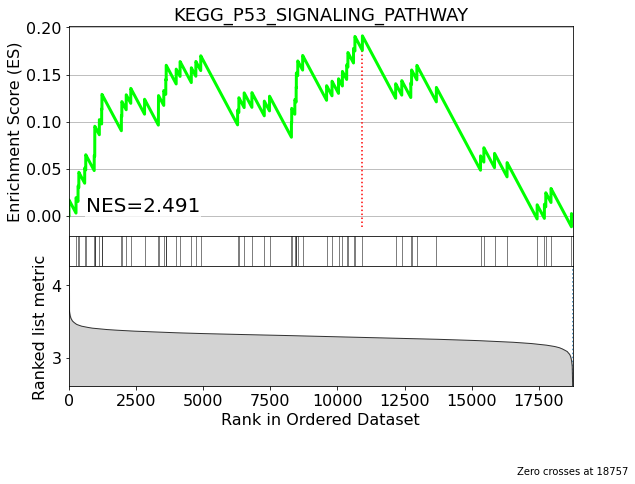

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "KEGG_P53_SIGNALING_PATHWAY", 
                             c2_kegg_gmt, 
                             result_kegg, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-KEGG_P53_SIGNALING_PATHWAY.pdf", bbox_inches='tight')

### KEGG_ACUTE_MYELOID_LEUKEMIA

In [ ]:
result_kegg.loc['KEGG_ACUTE_MYELOID_LEUKEMIA',:].leading_edge

'PIK3R1,MAP2K2,PIK3R5,PIK3CD,MAP2K1,SOS1,RUNX1T1,PIM2,PIK3R2,RAF1,PIK3CG,BRAF,NFKB1,NRAS,MAPK1,MAPK3,LEF1,CCND1,STAT3,TCF7L2,RPS6KB1,AKT1,PIK3CB,CEBPA,TCF7L1,RUNX1,KIT'

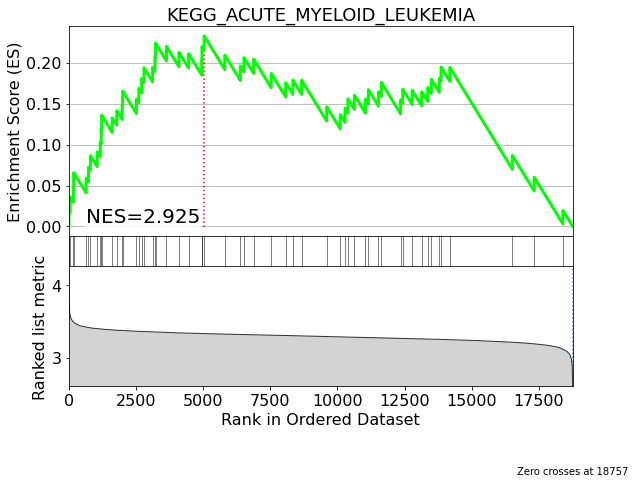

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "KEGG_ACUTE_MYELOID_LEUKEMIA", 
                             c2_kegg_gmt, 
                             result_kegg, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-KEGG_ACUTE_MYELOID_LEUKEMIA.pdf", bbox_inches='tight')

### GOBP_RNA_MODIFICATION

In [ ]:
result_go.loc['GOBP_RNA_MODIFICATION',:].leading_edge

'ANKRD16,FTSJ3,ALKBH1,KTI12,TRIT1,RPUSD4,METTL4,TRMT10C,ELP3,METTL14,TRMT12,TRUB2,URM1,NSUN6,SSB,ELP6,TRMT10A,DUS2,RBM15,TPRKB,GTPBP3,PUS7,ZC3H13,NAF1,PARN,ELP2,CBLL1,TRMT2B,TARBP1,PUSL1,DUS1L,METTL1,METTL8,CTU2,NUDT16,FTO,METTL3,GAR1,PUS7L,MEPCE,MTO1,MOCS3,RPUSD3,TRUB1,RPUSD2,AICDA,RNMT,DKC1,DIMT1,ZCCHC4,ELP5,WDR4,TRMT11,NSUN4,METTL5,BCDIN3D,CTU1,AARS2,ELP4,THADA,ALKBH8'

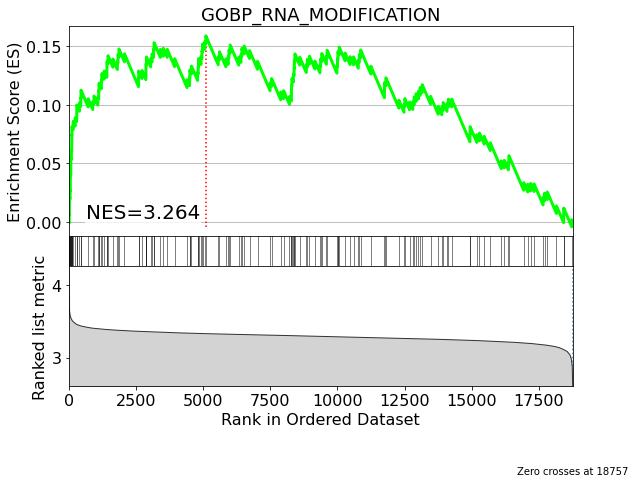

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOBP_RNA_MODIFICATION", 
                             c5_go_gmt, 
                             result_go, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-GOBP_RNA_MODIFICATION.pdf", bbox_inches='tight')

### GOCC_SPLICEOSOMAL_COMPLEX

In [ ]:
result_go.loc['GOCC_SPLICEOSOMAL_COMPLEX',:].leading_edge

'RBM3,PNN,SNRPF,CTNNBL1,RBMXL2,CWF19L1,ZRSR2,SNW1,HNRNPU,PRPF8,SNRNP40,HNRNPF,WBP4,ZCRB1,HNRNPH3,SYF2,SREK1,ZNF830,HNRNPR,LSM2,PPIL3,PPIE,AAR2,SYNCRIP,SNRPC,SNRNP70,LSM5,AQR,SF3B5,PPIL1,HNRNPK,BUD13,LUC7L3,WBP11,PHF5A'

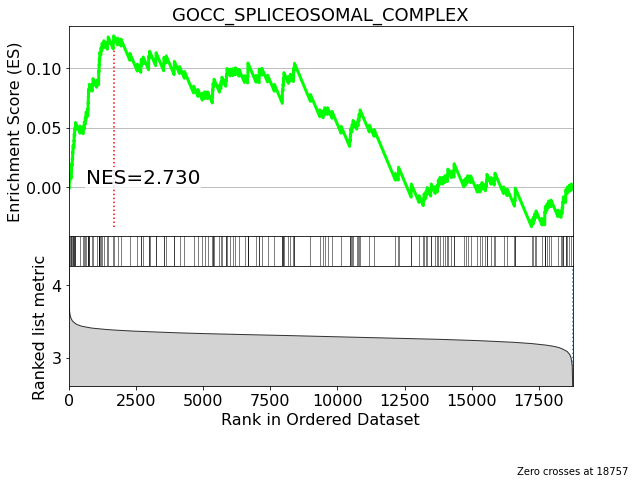

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOCC_SPLICEOSOMAL_COMPLEX", 
                             c5_go_gmt, 
                             result_go, compact=False)
# fig.savefig("plots/gesa_running_sum_GOBP_RNA_MODIFICATION.pdf", bbox_inches='tight')

### GOBP_RNA_SPLICING

In [ ]:
result_go.loc['GOBP_RNA_SPLICING',:].leading_edge

'PPIG,CWF19L1,ZRSR2,METTL14,HNRNPU,FAM172A,ZCRB1,POLR2L,RBM15,ZC3H13,SRSF10,ZNF830,PRMT7,METTL3,ACIN1,SYNCRIP,SNRPC,LSM5,GEMIN4,SF3B5,PPIL1,SNUPN,RBFOX2,HNRNPK,CELF3,LUC7L3,PPARGC1A,WBP11,GPATCH1,ESRP1,TSEN34,SRSF11,GEMIN8,PNN,SNRPF,CTNNBL1,POLR2A,SRPK3,TRA2B,SNRPB,ZNF326,RTCB,SNW1,PCBP2,DHX9,RAVER1,SNRNP40,IVNS1ABP,DAZAP1,PTBP1,HNRNPH3,SAP18,CSTF2,SREK1,HNRNPR,LSM2,THRAP3,PPIL3,SNIP1,PPIE,AAR2,DDX20,CSTF3,SNRNP70,AQR,SNRPA,POLR2D,RBM10,DDX1,PHF5A,RBM3,PRCC,PTBP3,PUF60,SCAF11,PRPF8,RBM19,CPSF7,REST,RBM4B,CPSF4,BUD13,CPSF3,RBMXL2,SLC38A2,KHDRBS2,METTL4,ZMAT5,DYRK1A,SF1,SF3B4,HNRNPF,WBP4,CPSF1,PPP1R9B,CHERP,PAPOLA,SYMPK,CELF4,SYF2,ZRANB2,RNPC3,SPEN,PRX,HNRNPH2,SRSF6,GEMIN5,PSIP1,RAVER2,ZC3H10,SRRT,SRPK1,WDR83,KHDRBS3'

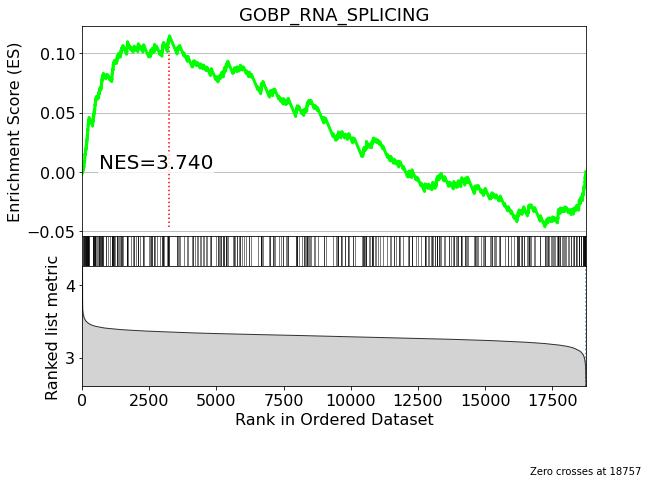

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOBP_RNA_SPLICING", 
                             c5_go_gmt, 
                             result_go, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-GOBP_RNA_SPLICING.pdf", bbox_inches='tight')

### GOCC_MRNA_EDITING_COMPLEX 

In [ ]:
result_go.loc['GOBP_MRNA_MODIFICATION',:].leading_edge

'PCIF1,METTL8,A1CF,PUS3,APOBEC1,TRMT61A,PUS1,METTL3,TRMT61B,PUS7,ZC3H13,TRUB1,TRMT10C,BAG4,METTL14,CBLL1,DKC1,APOBEC2'

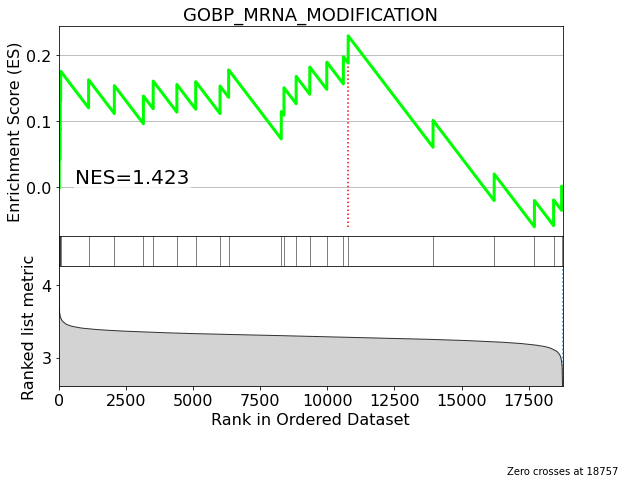

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOBP_MRNA_MODIFICATION", 
                             c5_go_gmt, 
                             result_go, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-GOBP_MRNA_MODIFICATION.pdf", bbox_inches='tight')

## Sensitivity hits

### INTS5 related 

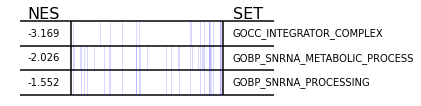

In [844]:
fig_table = blitz.plot.top_table(
    signature, c5_go_gmt, 
    result_go[result_go.leading_edge.str.contains('INTS5')],
    n=3
)

### GOCC_INTEGRATOR_COMPLEX

In [26]:
result_go.loc['GOCC_INTEGRATOR_COMPLEX',:].leading_edge

'INTS8,NIPBL,INTS12,INTS1,INTS9,INTS7,INTS5,INTS4,CT45A1,INTS6,SAGE1'

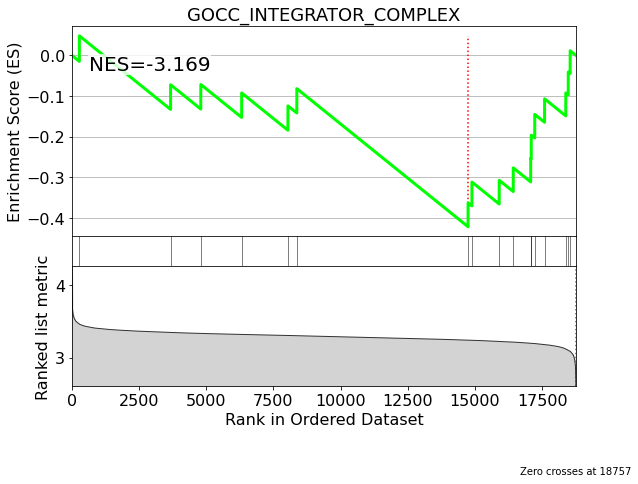

In [57]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOCC_INTEGRATOR_COMPLEX", 
                             c5_go_gmt, 
                             result_go, compact=False)
fig#.savefig("plots/CRISPRi-rho-gsea-GOCC_INTEGRATOR_COMPLEX.pdf", bbox_inches='tight')

### GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY

In [52]:
result_go.loc['GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY',:].leading_edge

'EZH2,N6AMT1,PNMT,FTSJ3,NSD1,METTL4,DPH5,DNMT3A,TRMT10C,METTL14,KMT2A,WDR82,KMT2D,NSUN6,ICMT,METTL22,TRMT10A,SETD2,METTL1,TRMT2B,TARBP1,METTL21C,ASMT,SMYD3,METTL8,PRMT7,METTL3,MEPCE,PRDM9,RNMT,DIMT1,COQ5,PEMT,ZCCHC4,EED,METTL18,WDR4,MEN1,DNMT3B,NSUN4,CARM1,SMYD2,TRMT11,COMTD1,METTL5,DOT1L,ASH1L,SETD1A,COQ3'

In [60]:
# # plot the enrichment results and save to pdf
# fig = blitz.plot.running_sum(signature, "GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY", 
#                              c5_go_gmt, 
#                              result_go, compact=False)
# fig#.savefig("plots/CRISPRi-rho-gsea-GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY.pdf", bbox_inches='tight')

### GOBP_NEGATIVE_REGULATION_OF_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY_BY_P53_CLASS_MEDIATOR

In [ ]:
result_go.loc['GOBP_NEGATIVE_REGULATION_OF_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY_BY_P53_CLASS_MEDIATOR',:].leading_edge

'CD74,MUC1,KDM1A,CD44,BCL2,ARMC10,PTTG1IP,TRIAP1'

In [59]:
# # plot the enrichment results and save to pdf
# fig = blitz.plot.running_sum(
#     signature, 
#     "GOBP_NEGATIVE_REGULATION_OF_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY_BY_P53_CLASS_MEDIATOR", 
#     c5_go_gmt, 
#     result_go, compact=False)

# fig

### GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_UNFOLDED_PROTEIN_RESPONSE

In [ ]:
result_go.loc['GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_UNFOLDED_PROTEIN_RESPONSE',:].leading_edge

'FICD,NCK1,ERN1,XBP1,DDRGK1,PTPN2,PIK3R1,ATF6,BAK1,HSPA5,ATF6B,BAX,PPP1R15A,COPS5,ABCA7,BOK,PTPN1,BCL2L11,DNAJB9'

In [58]:
# # plot the enrichment results and save to pdf
# fig = blitz.plot.running_sum(
#     signature, 
#     "GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_UNFOLDED_PROTEIN_RESPONSE", 
#     c5_go_gmt, result_go, compact=False
# )

# fig.savefig("plots/CRISPRi-rho-gsea-GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_UNFOLDED_PROTEIN_RESPONSE.pdf", bbox_inches='tight')

### KEGG_RNA_DEGRADATION

In [ ]:
result_kegg.loc['KEGG_RNA_DEGRADATION',:].leading_edge

'EDC3,CNOT6L,CNOT4,PATL1,EXOSC6,DCPS,ENO2,CNOT8,LSM7,LSM3,CNOT3,MPHOSPH6,DDX6,CNOT2,CNOT6,EXOSC9,CNOT7,TTC37,CNOT10,EXOSC10,C1D,ENO1,EXOSC1,DCP1A,SKIV2L,EXOSC4,EXOSC3,WDR61,DCP2,CNOT1,DIS3'

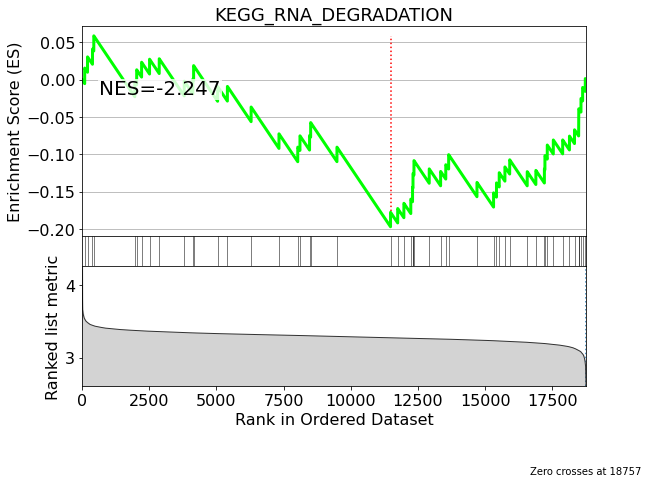

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "KEGG_RNA_DEGRADATION", 
                             c2_kegg_gmt, 
                             result_kegg, compact=False)

fig.savefig("plots/CRISPRi-rho-gsea-KEGG_RNA_DEGRADATION.pdf", bbox_inches='tight')

# 

In [846]:
!date

Sat Sep 17 19:20:21 PDT 2022
